# Testing GNN Training

In [1]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns

import torch
from torch_geometric.data import Data, DataLoader
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
import scipy as sp
import wandb

import warnings

warnings.filterwarnings("ignore")
sys.path.append("../../")
device = "cuda" if torch.cuda.is_available() else "cpu"

from models.submodels.agnn import GraphLevelAGNN

In [2]:
# load config
with open("graphlevel_config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [3]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/LRP_Study_C/1wvgwzkp/checkpoints/last.ckpt"
model = GraphLevelAGNN.load_from_checkpoint(checkpoint_path).to(device)

In [4]:
model.hparams["datatype_split"] = [200, 100, 100]

## Test Dataloading

In [5]:
model.setup(stage="fit")

Setting up dataset


100%|██████████| 100/100 [00:00<00:00, 224.49it/s]


In [6]:
for batch in model.train_dataloader():
    sample = batch.to(device)
    break

In [7]:
with torch.no_grad():
    model.eval()
    output, attention_log = model(sample.x, sample.edge_index, sample.batch, log_attention=True)

<AxesSubplot:ylabel='Density'>

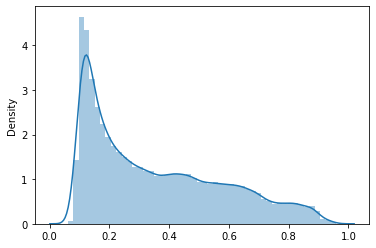

In [8]:
sns.distplot(torch.stack(attention_log).max(dim=0)[0].cpu().numpy())

In [17]:
attention_cut = 0.2
stacked_attention = torch.stack(attention_log).max(dim=0)[0]

print(f"Number of edges passing cut: {stacked_attention[stacked_attention > attention_cut].shape[0]}, meaning {stacked_attention[stacked_attention > attention_cut].shape[0]/sample.x.shape[0]} edges per node")

Number of edges passing cut: 106941, meaning 5.8281650226170365 edges per node


In [5]:
top_dir = "/global/cfs/cdirs/m3443/data/TrackLRP/attention_cut_dir_1"
with torch.no_grad():
    model.eval()
    for dataset, dataname in zip([model.trainset, model.valset, model.testset], ["train", "val", "test"]):
        dataloader = DataLoader(dataset, batch_size=1, num_workers=0)
        save_dir = os.path.join(top_dir, dataname)
        os.makedirs(save_dir, exist_ok=True)
        for i, batch in enumerate(tqdm(dataloader)):
            sample = batch.to(device)
            output, attention_log = model(sample.x, sample.edge_index, sample.batch, log_attention=True)
            stacked_attention = torch.stack(attention_log).max(dim=0)[0]
            sample.max_attention = stacked_attention
            torch.save(sample.cpu(), os.path.join(save_dir, f"{i}.pt"))

100%|██████████| 1000/1000 [00:05<00:00, 175.27it/s]


In [6]:
test_sample = torch.load(os.path.join(save_dir, "1.pt"))

In [7]:
test_sample

DataBatch(x=[93, 2], edge_index=[2, 839], y=[839], modulewise_true_edges=[82, 2], signal_true_edges=[82, 2], pt=[93], pid=[93], y_pid=[839], pid_signal=[839], y_trigger=[1], batch=[93], ptr=[2], max_attention=[839, 1])

In [41]:
test_sample.edge_index[:, test_sample.max_attention.squeeze() > 0.9].shape

torch.Size([2, 1470])

<AxesSubplot:ylabel='Count'>

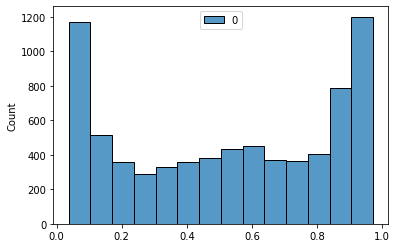

In [29]:
sns.histplot(test_sample.max_attention.numpy())

In [ ]:
num_nodes = 100

In [18]:
sample

DataBatch(x=[18349, 2], edge_index=[2, 166775], y=[166775], modulewise_true_edges=[16149, 2], signal_true_edges=[16149, 2], pt=[18349], pid=[18349], y_pid=[166775], pid_signal=[166775], y_trigger=[200], batch=[18349], ptr=[201])

In [23]:
rand_k = 5
# torch.randint(sample.ptr[0], sample.ptr[1], (sample.ptr[1] - sample.ptr[0], rand_k))

all_random_k = [torch.randint(sample.ptr[i], sample.ptr[i+1], (sample.ptr[i+1] - sample.ptr[i], rand_k), device=) for i in range(sample.ptr.shape[0] - 1)]

In [46]:
sample.ptr

tensor([    0,    85,   170,   261,   351,   437,   516,   607,   695,   780,
          868,   955,  1052,  1147,  1237,  1328,  1420,  1518,  1613,  1709,
         1808,  1901,  1989,  2084,  2172,  2265,  2354,  2442,  2532,  2623,
         2709,  2812,  2899,  2989,  3082,  3171,  3268,  3364,  3459,  3551,
         3639,  3724,  3822,  3911,  4011,  4105,  4195,  4291,  4387,  4487,
         4579,  4676,  4763,  4852,  4935,  5035,  5126,  5208,  5300,  5379,
         5478,  5574,  5668,  5756,  5858,  5953,  6037,  6130,  6225,  6317,
         6407,  6502,  6598,  6691,  6788,  6881,  6971,  7055,  7139,  7239,
         7333,  7420,  7509,  7606,  7700,  7786,  7878,  7970,  8063,  8160,
         8262,  8348,  8442,  8535,  8628,  8719,  8817,  8907,  8996,  9081,
         9167,  9264,  9345,  9432,  9524,  9618,  9710,  9798,  9885,  9985,
        10085, 10174, 10263, 10363, 10454, 10537, 10627, 10722, 10812, 10910,
        11007, 11098, 11191, 11283, 11372, 11469, 11552, 11636, 

In [47]:
all_random_k

tensor([[   31,    56,    36,    68,    13],
        [   13,    18,    15,    70,    56],
        [   42,    35,    41,    61,    50],
        ...,
        [18269, 18277, 18334, 18330, 18277],
        [18278, 18279, 18278, 18320, 18261],
        [18275, 18292, 18292, 18343, 18316]])

In [28]:
all_random_k = torch.cat(all_random_k, dim=0)

In [30]:
all_random_k.shape

torch.Size([18349, 5])

In [45]:
torch.stack([all_random_k, torch.tile(torch.arange(all_random_k.shape[0]), (rand_k, 1)).T]).flatten(1)

tensor([[   31,    56,    36,  ..., 18292, 18343, 18316],
        [    0,     0,     0,  ..., 18348, 18348, 18348]])

In [51]:
sample.batch.unique(return_inverse=True)[1]

tensor([  0,   0,   0,  ..., 199, 199, 199], device='cuda:0')

In [4]:
grav_fact = 100.
for d in np.arange(0, 1, 0.1):
    print(d, np.exp(-grav_fact*d**2))

0.0 1.0
0.1 0.3678794411714422
0.2 0.018315638888734165
0.30000000000000004 0.00012340980408667932
0.4 1.1253517471925872e-07
0.5 1.3887943864964021e-11
0.6000000000000001 2.319522830243553e-16
0.7000000000000001 5.242885663363426e-22
0.8 1.603810890548615e-28
0.9 6.639677199580735e-36


In [2]:
# Create torch tensor arranged 1 to 100
x = torch.arange(1, 101, dtype=torch.float32)
# Stack the rows into a 10x10 tensor
x = x.reshape(10, 10)

In [3]:
torch.rand(10,3)

tensor([[0.8733, 0.5512, 0.7486],
        [0.6804, 0.0180, 0.1734],
        [0.7409, 0.8652, 0.7519],
        [0.6434, 0.5530, 0.5918],
        [0.3101, 0.7801, 0.2149],
        [0.6059, 0.3508, 0.4048],
        [0.6631, 0.9070, 0.5263],
        [0.6359, 0.4484, 0.0595],
        [0.6000, 0.8142, 0.1005],
        [0.5426, 0.0608, 0.5546]])

In [6]:
A = torch.tensor([[0, 1, 2, 3, 4], [1, 2, 3, 4, 5]])
B = torch.tensor([[3, 4, 5], [4, 5, 6]])

In [8]:
# Take the union of A and B
C = torch.cat((A, B), dim=1)

In [9]:
C

tensor([[0, 1, 2, 3, 4, 3, 4, 5],
        [1, 2, 3, 4, 5, 4, 5, 6]])

In [10]:
torch.unique(C, dim=1)

tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 6]])